<h1 style="text-align:center">Deep Learning   </h1>
<h1 style="text-align:center"> Lab Session 2 - 1.5 Hours </h1>
<h1 style="text-align:center"> Convolutional Neural Network (CNN) for Handwritten Digits Recognition</h1>

The aim of this session is to practice with Convolutional Neural Networks. Each group should fill and run appropriate notebook cells. 

Follow instructions step by step until the end and submit your complete notebook as an archive (tar -cf groupXnotebook.tar DL_lab2/).

Do not forget to run all your cells before generating your final report and do not forget to include the names of all participants in the group. The lab session should be completed by May 29th 2019 (23:59:59 CET).

# Introduction

In the last Lab Session, you built a Multilayer Perceptron for recognizing hand-written digits from the MNIST data-set. The best achieved accuracy on testing data was about 97%.  Can  you do better than these results using a deep CNN ?
In this Lab Session, you will build, train and optimize in TensorFlow one of the early Convolutional Neural Networks,  **LeNet-5**, to go to  more than 99% of accuracy. 






# Load MNIST Data in TensorFlow
Run the cell below to load the MNIST data that comes with TensorFlow. You will use this data in **Section 1** and **Section 2**.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import time
current_milli_time = lambda: int(round(time.time() * 1000))
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels
print("Image Shape: {}".format(X_train[0].shape))
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

epsilon = 1e-10 # this is a parameter you will use later

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Image Shape: (784,)
Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


In [5]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import time
import humanize
import argparse
import os
import logging
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt

# Can be commented out if raises error
matplotlib.rc_file('/mnt/workspace/.config/matplotlib/matplotlibrc')
logger = logging.getLogger(__name__)


def read_tbevents(filepath) -> EventAccumulator:
    """
        Just a simple util for reading tensorboard files
    """
    event_acc = EventAccumulator(filepath)
    logger.warning('Starting loading the event file in %s. Might take a while' % (filepath))
    t0 = time.time()
    event_acc.Reload()
    t_diff = time.time() - t0
    logger.info('Loading from %s completed in %s' % (filepath, humanize.naturaldelta(t_diff)))
    return event_acc

# Section 1 : My First Model in TensorFlow

Before starting with CNN, let's train and test in TensorFlow the example
**y=softmax(Wx+b)** seen in the first lab. 

This model reaches an accuracy of about 92 %.
You will also learn how to launch the TensorBoard https://www.tensorflow.org/get_started/summaries_and_tensorboard to visualize the computation graph, statistics and learning curves. 

<b> Part 1 </b> : Read carefully the code in the cell below. Run it to perform training. 

In [2]:
#STEP 1

# Parameters
learning_rate = 0.01
training_epochs = 40
batch_size = 128
display_step = 1
logs_path = 'log_files/'  # useful for tensorboard

# tf Graph Input:  mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name='InputData')
# 0-9 digits recognition,  10 classes
y = tf.placeholder(tf.float32, [None, 10], name='LabelData')

# Set model weights
W = tf.Variable(tf.zeros([784, 10]), name='Weights')
b = tf.Variable(tf.zeros([10]), name='Bias')

# Construct model and encapsulating all ops into scopes, making Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Model
    pred = tf.nn.softmax(tf.matmul(x, W) + b) # Softmax
with tf.name_scope('Loss'):
    # Minimize error using cross entropy
    # We use tf.clip_by_value to avoid having too low numbers in the log function
    cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(tf.clip_by_value(pred, epsilon, 1.0)), reduction_indices=1))
with tf.name_scope('SGD'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
with tf.name_scope('Accuracy'):
    # Accuracy
    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()
# Create a summary to monitor cost tensor
tf.summary.scalar("Loss", cost)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("Accuracy", acc)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

#STEP 2 

# Launch the graph for training
with tf.Session() as sess:
    sess.run(init)
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=(i==0))
            #print(np.shape(batch_xs), np.shape(batch_ys))
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            _, c, summary = sess.run([optimizer, cost, merged_summary_op], feed_dict={x: batch_xs, y: batch_ys})
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * total_batch + i)
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch: ", '%02d' % (epoch+1), "  =====> Loss=", "{:.9f}".format(avg_cost))

    print("Optimization Finished!")
    summary_writer.flush()

    # Test model
    # Calculate accuracy
    print("Accuracy:", acc.eval({x: mnist.test.images, y: mnist.test.labels}))

Epoch:  01   =====> Loss= 1.288112997
Epoch:  02   =====> Loss= 0.732736631
Epoch:  03   =====> Loss= 0.600303860
Epoch:  04   =====> Loss= 0.536784799
Epoch:  05   =====> Loss= 0.497726638
Epoch:  06   =====> Loss= 0.471259499
Epoch:  07   =====> Loss= 0.451301391
Epoch:  08   =====> Loss= 0.435882446
Epoch:  09   =====> Loss= 0.423383058
Epoch:  10   =====> Loss= 0.413102194
Epoch:  11   =====> Loss= 0.404587487
Epoch:  12   =====> Loss= 0.396836265
Epoch:  13   =====> Loss= 0.390176678
Epoch:  14   =====> Loss= 0.384495573
Epoch:  15   =====> Loss= 0.379282909
Epoch:  16   =====> Loss= 0.374565838
Epoch:  17   =====> Loss= 0.370448530
Epoch:  18   =====> Loss= 0.366439742
Epoch:  19   =====> Loss= 0.362938127
Epoch:  20   =====> Loss= 0.359739548
Epoch:  21   =====> Loss= 0.356577252
Epoch:  22   =====> Loss= 0.353760000
Epoch:  23   =====> Loss= 0.351360008
Epoch:  24   =====> Loss= 0.348841788
Epoch:  25   =====> Loss= 0.346417573
Epoch:  26   =====> Loss= 0.344472817
Epoch:  27  

<b> Part 2  </b>: Using Tensorboard, we can  now visualize the created graph, giving you an overview of your architecture and how all of the major components  are connected. You can also see and analyse the learning curves. 

To launch tensorBoard: 
- Open a Terminal and run the command line **"tensorboard --logdir=lab_2/log_files/"**
- Click on "Tensorboard web interface" in Zoe  


Enjoy It !! 


# Section 2 : The 99% MNIST Challenge !

<b> Part 1 </b> : LeNet5 implementation

You are now familar with **TensorFlow** and **TensorBoard**. In this section, you are to build, train and test the baseline [LeNet-5](http://yann.lecun.com/exdb/lenet/)  model for the MNIST digits recognition problem.  

Then, you will make some optimizations to get more than 99% of accuracy.

For more informations, have a look at this list of results: http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html


<img src="lenet.png" width="800" height="600" align="center">





The LeNet architecture takes a 28x28xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

--------------------------
**Layer 1 - Convolution (5x5):** The output shape should be 28x28x6. **Activation:** ReLU. **MaxPooling:** The output shape should be 14x14x6.

**Layer 2 - Convolution (5x5):** The output shape should be 10x10x16. **Activation:** ReLU. **MaxPooling:** The output shape should be 5x5x16.

**Flatten:** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.  You may need to use tf.reshape.

**Layer 3 - Fully Connected:** This should have 120 outputs. **Activation:** ReLU.

**Layer 4 - Fully Connected:** This should have 84 outputs. **Activation:** ReLU.

**Layer 5 - Fully Connected:** This should have 10 outputs. **Activation:** softmax.


<b> Question 2.1.1 </b>  Implement the Neural Network architecture described above.
For that, your will use classes and functions from  https://www.tensorflow.org/api_docs/python/tf/nn. 

We give you some helper functions for weigths and bias initilization. Also you can refer to section 1. 


In [2]:
# Functions for weigths and bias initilization 
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0., shape=shape)
  return tf.Variable(initial)

In [3]:
def LeNet5_Model(image):    
    # your inmplementation goes here
    with tf.name_scope("layer1"):
        out0 = tf.reshape(image, [-1, 28, 28, 1]) # [batch_size, 28, 28, 1]
        w1 = weight_variable(shape=[5, 5, 1, 6])
        b1 = bias_variable(shape=[6])
        out1 = tf.nn.conv2d(input=out0, filter=w1, strides=[1,1,1,1], padding="SAME") + b1 # [batch_size, 28, 28, 6]
        out1 = tf.nn.relu(features=out1) # [batch_size, 28, 28, 6]
        out1 = tf.nn.max_pool(value=out1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME") # [batch_size, 14, 14, 6]
    
    with tf.name_scope("layer2"):
        w2 = weight_variable(shape=[5, 5, 6, 16])
        b2 = bias_variable(shape=[16])
        out2 = tf.nn.conv2d(input=out1, filter=w2, strides=[1,1,1,1], padding="VALID") + b2 # [batch_size, 10, 10, 16]
        out2 = tf.nn.relu(features=out2) # [batch_size, 10, 10, 16]
        out2 = tf.nn.max_pool(value=out2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME") # [batch_size, 5, 5, 16]
        
    with tf.name_scope("flatten"):
        conv_feature = tf.reshape(out2, [-1, 5 * 5 * 16])
    
    with tf.name_scope("layer3"):
        w3 = weight_variable(shape=[5 * 5 * 16, 120])
        b3 = bias_variable(shape=[120])
        out3 = tf.matmul(a=conv_feature, b=w3) + b3 # [batch_size, 120]
        out3 = tf.nn.relu(features=out3) # [batch_size, 120]
        
    with tf.name_scope("layer4"):
        w4 = weight_variable(shape=[120, 84])
        b4 = bias_variable(shape=[84])
        out4 = tf.matmul(a=out3, b=w4) + b4 # [batch_size, 84]
        out4 = tf.nn.relu(features=out4) # [batch_size, 84]
    
    with tf.name_scope("layer5"):
        w5 = weight_variable(shape=[84, 10])
        b5 = bias_variable(shape=[10])
        out5 = tf.matmul(a=out4, b=w5) + b5 # [batch_size, 10]
        #out5 = tf.nn.softmax(out5) # [batch_size, 10]
    
    return out5

<b> Question 2.1.2. </b>  Calculate the number of parameters of this model 

+ The first convolutional layer contains 5 * 5 * 1 * 6 + 6 = 156 parameters
+ The second convolutional layer contains 5 * 5 * 6 * 16 + 16 = 2416 parameters
+ The first fully connected layer contains 5 * 5 * 6 * 120 + 120 = 18120 parameters
+ The second fully connected layer contains 120 * 84 + 84 = 10164 parameters
+ The third fully connected layer contains 84 * 10 + 10 = 850 parameters
+ The total number of parameters in model is 156 + 2416 + 18120 + 10164 + 850 = 31706 parameters

<b> Question 2.1.3. </b>  Define your model, its accuracy and the loss function according to the following parameters (you can look at Section 1 to see what is expected):

     Learning rate: 0.001
     Loss Fucntion: Cross-entropy
     Optimizer: tf.train.GradientDescentOptimizer
     Number of epochs: 40
     Batch size: 128

In [4]:
tf.reset_default_graph() # reset the default graph before defining a new model

# Parameters
learning_rate = 0.001
training_epochs = 40
batch_size = 128
test_batch_size = 5000
display_step = 1
logs_path = 'log_files_cnn_sgd/'

# Model, loss function and accuracy
# tf Graph Input:  mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name="InputData")
# 0-9 digits recognition,  10 classes
y = tf.placeholder(tf.float32, [None, 10], name="LabelData")
# Define model
with tf.name_scope("Model"):
    pred = LeNet5_Model(image=x)
    
# Define loss function
with tf.name_scope('Loss'):
    # Minimize error using cross entropy
    # We use tf.clip_by_value to avoid having too low numbers in the log function
    # cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(tf.clip_by_value(pred, epsilon, 1.0)), reduction_indices=1))
    # Define cross-entropy cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

# Define optimizer
with tf.name_scope('SGD'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    
# Define accuracy
with tf.name_scope('Accuracy'):
    # Accuracy
    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

# Define saver to save model
with tf.name_scope('Saver'):
    saver = tf.train.Saver()

<b> Question 2.1.4. </b>  Implement the evaluation function for accuracy computation 

In [9]:
def evaluate(logits, labels):
    # logits will be the outputs of your model, labels will be one-hot vectors corresponding to the actual labels
    # logits and labels are numpy arrays
    # this function should return the accuracy of your model
    ### QUESTION: Why we need to implement this function? Why do not we execute node "acc" with feed_dict containing testing data as in Section 1 ???
    pass

<b> Question 2.1.5. </b>  Implement training pipeline and run the training data through it to train the model.

- Before each epoch, shuffle the training set. 
- Print the loss per mini batch and the training/validation accuracy per epoch. (Display results every 100 epochs)
- Save the model after training
- Print after training the final testing accuracy 



In [6]:
# Initializing the variables
init = tf.global_variables_initializer()
# Create a summary to monitor cost tensor
tf.summary.scalar("Loss_LeNet-5_SGD", cost)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("Accuracy_LeNet-5_SGD", acc)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# Initializing the variables
def train(init, sess, logs_path, n_epochs, batch_size, optimizer, cost, merged_summary_op):
    # optimizer and cost are the same kinds of objects as in Section 1
    # Train your model
    # Initialize variable
    sess.run(init)
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    # Training cycle
    train_time = 0.0
    for epoch in range(n_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=(i==0))
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            start_train_time = current_milli_time()
            _, c, summary = sess.run([optimizer, cost, merged_summary_op],
                                     feed_dict={x: batch_xs, y: batch_ys})
            train_time = train_time + current_milli_time() - start_train_time
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * total_batch + i)
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            train_acc = 0.0
            total_batch = int(mnist.train.num_examples/test_batch_size)
            for i in range(total_batch):
                train_acc = train_acc + acc.eval({x:mnist.train.images[i * test_batch_size : (i + 1) * test_batch_size], 
                                                  y:mnist.train.labels[i * test_batch_size : (i + 1) * test_batch_size]})
            train_acc = train_acc / total_batch 
            val_acc = acc.eval({x:mnist.validation.images, y:mnist.validation.labels})
            print("Epoch", epoch + 1, ", average loss per minibatch:", avg_cost, ", train_acc:", train_acc, ", val_acc:", val_acc)

    print("Optimization Finished!")
    file_path = "./model_cnn_sgd_epoch" + str(n_epochs + 1) + "/model.ckpt"
    save_path = saver.save(sess, file_path)
    summary_writer.flush()

    # Test model
    # Calculate accuracy
    print("Accuracy on testing data using Gradient Descent Optimizer:", acc.eval({x: mnist.test.images, y: mnist.test.labels}))
    print("Training time on testing data using Gradient Descent Optimizer in minute:", train_time / (1000 * 60))
    return

with tf.Session() as sess:
    train(init, sess, logs_path, training_epochs, batch_size, optimizer, cost, merged_summary_op)

Epoch 1 , average loss per minibatch: 2.293979650888687 , train_acc: 0.2070909088308161 , val_acc: 0.2174
Epoch 2 , average loss per minibatch: 2.2655264392043604 , train_acc: 0.27712727134877985 , val_acc: 0.2806
Epoch 3 , average loss per minibatch: 2.220714932555086 , train_acc: 0.34989090941169043 , val_acc: 0.3508
Epoch 4 , average loss per minibatch: 2.1226041828280007 , train_acc: 0.4485636353492737 , val_acc: 0.4544
Epoch 5 , average loss per minibatch: 1.874300229243743 , train_acc: 0.6821454600854353 , val_acc: 0.682
Epoch 6 , average loss per minibatch: 1.3671125834916293 , train_acc: 0.7688727378845215 , val_acc: 0.7746
Epoch 7 , average loss per minibatch: 0.8973591713916453 , train_acc: 0.8063272779638117 , val_acc: 0.8116
Epoch 8 , average loss per minibatch: 0.663079536322392 , train_acc: 0.8389818126505072 , val_acc: 0.8426
Epoch 9 , average loss per minibatch: 0.5444610709354875 , train_acc: 0.8629636385224082 , val_acc: 0.8676
Epoch 10 , average loss per minibatch: 0

<b> Question 2.1.6 </b> : Use TensorBoard to visualise and save loss and accuracy curves. 
You will save figures in the folder **"lab_2/MNIST_figures"** and display them in your notebook.

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


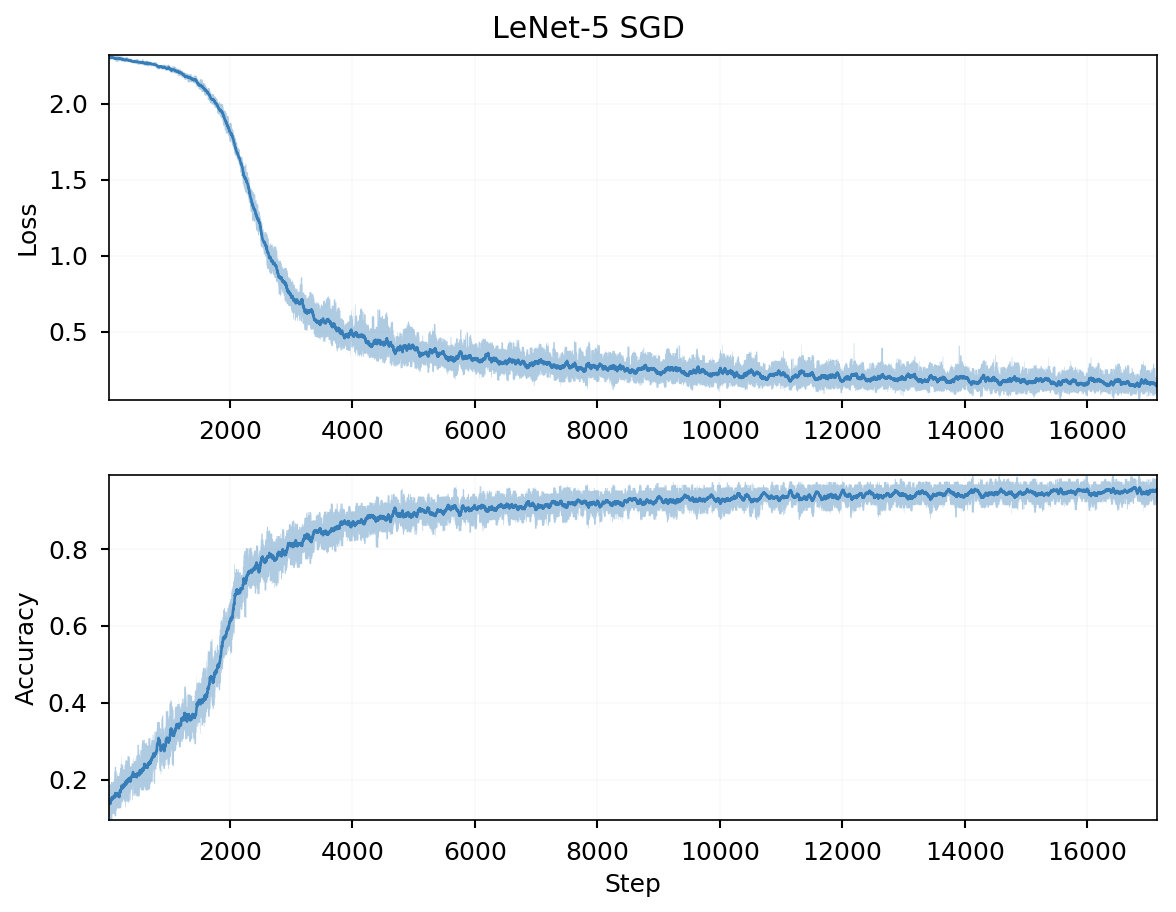

In [59]:
fig, (ax0, ax1) = plt.subplots(2, 1)

# ea = read_tbevents('./log_files_cnn_sgd/')
data = pd.DataFrame(ea.Scalars('Loss_LeNet-5_SGD'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax0.plot(data_m.step, data_m.value)
ax0.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)

data = pd.DataFrame(ea.Scalars('Accuracy_LeNet-5_SGD'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax1.plot(data_m.step, data_m.value)
ax1.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)


ax0.set_ylabel('Loss')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Step')
fig.suptitle('LeNet-5 SGD', y=1.01)

plt.show()

```
<img src="MNIST_figures/loss_lenet5_sgd.PNG" width="800" height="600" align="center">
<img src="MNIST_figures/accuracy_lenet5_sgd.PNG" width="800" height="600" align="center">
```

<b> Part 2 </b> : LeNET 5 Optimization


<b> Question 2.2.1 </b>

- Retrain your network with AdamOptimizer and then fill the table above:


| Optimizer            |  Gradient Descent  |    AdamOptimizer    |
|----------------------|--------------------|---------------------|
| Testing Accuracy     |       95.58 %      |       98.79 %       |       
| Training Time        |       11 min       |       11.2 min      |  

- Which optimizer gives the best accuracy on test data?

**Your answer:** AdamOptimizer


In [7]:
tf.reset_default_graph()
# your implementation goes here
# Parameters
learning_rate = 0.001
training_epochs = 40
batch_size = 128
test_batch_size = 5000
display_step = 1
logs_path = 'log_files_cnn_adam/'

# Model, loss function and accuracy
# tf Graph Input:  mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name="InputData")
# 0-9 digits recognition,  10 classes
y = tf.placeholder(tf.float32, [None, 10], name="LabelData")
# Define model
with tf.name_scope("Model"):
    pred = LeNet5_Model(image=x)
    
# Define loss function
with tf.name_scope('Loss'):
    # Minimize error using cross entropy
    # We use tf.clip_by_value to avoid having too low numbers in the log function
    # cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(tf.clip_by_value(pred, epsilon, 1.0)), reduction_indices=1))
    # Define cross-entropy cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

# Define optimizer
with tf.name_scope('AdamOptim'):
    # Gradient Descent
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
# Define accuracy
with tf.name_scope('Accuracy'):
    # Accuracy
    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

# Define saver to save model
with tf.name_scope('Saver'):
    saver = tf.train.Saver()
    
# Initializing the variables
init = tf.global_variables_initializer()
# Create a summary to monitor cost tensor
tf.summary.scalar("Loss_LeNet-5_Adam", cost)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("Accuracy_LeNet-5_Adam", acc)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# Initializing the variables
def train(init, sess, logs_path, n_epochs, batch_size, optimizer, cost, merged_summary_op):
    # optimizer and cost are the same kinds of objects as in Section 1
    # Train your model
    # Initialize variable
    sess.run(init)
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    # Training cycle
    train_time = 0.0
    for epoch in range(n_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=(i==0))
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            start_train_time = current_milli_time()
            _, c, summary = sess.run([optimizer, cost, merged_summary_op],
                                     feed_dict={x: batch_xs, y: batch_ys})
            train_time = train_time + current_milli_time() - start_train_time
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * total_batch + i)
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            train_acc = 0.0
            total_batch = int(mnist.train.num_examples/test_batch_size)
            for i in range(total_batch):
                train_acc = train_acc + acc.eval({x:mnist.train.images[i * test_batch_size : (i + 1) * test_batch_size], 
                                                  y:mnist.train.labels[i * test_batch_size : (i + 1) * test_batch_size]})
            train_acc = train_acc / total_batch 
            val_acc = acc.eval({x:mnist.validation.images, y:mnist.validation.labels})
            print("Epoch", epoch + 1, ", average loss per minibatch:", avg_cost, ", train_acc:", train_acc, ", val_acc:", val_acc)

    print("Optimization Finished!")
    file_path = "./model_cnn_adam_epoch" + str(n_epochs) + "/model.ckpt"
    save_path = saver.save(sess, file_path)
    summary_writer.flush()

    # Test model
    # Calculate accuracy
    print("Accuracy on testing data using Adam optimizer:", acc.eval({x: mnist.test.images, y: mnist.test.labels}))
    print("Training time on testing data using Adam optimizer in minute:", train_time / (1000 * 60))
    return

with tf.Session() as sess:
    train(init, sess, logs_path, training_epochs, batch_size, optimizer, cost, merged_summary_op)

Epoch 1 , average loss per minibatch: 0.35226648971264723 , train_acc: 0.9615454457022927 , val_acc: 0.967
Epoch 2 , average loss per minibatch: 0.09704160279570488 , train_acc: 0.9733636325055902 , val_acc: 0.9762
Epoch 3 , average loss per minibatch: 0.0676524821866416 , train_acc: 0.9826363596049222 , val_acc: 0.9824
Epoch 4 , average loss per minibatch: 0.05263815842143378 , train_acc: 0.9867818247188221 , val_acc: 0.9846
Epoch 5 , average loss per minibatch: 0.04299862964387054 , train_acc: 0.988890902562575 , val_acc: 0.9858
Epoch 6 , average loss per minibatch: 0.036869471622706915 , train_acc: 0.9915999932722612 , val_acc: 0.9884
Epoch 7 , average loss per minibatch: 0.030722734631236776 , train_acc: 0.9922363595529036 , val_acc: 0.9882
Epoch 8 , average loss per minibatch: 0.02576705746747235 , train_acc: 0.99169091202996 , val_acc: 0.9864
Epoch 9 , average loss per minibatch: 0.021558746140985387 , train_acc: 0.9936909025365656 , val_acc: 0.987
Epoch 10 , average loss per min

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


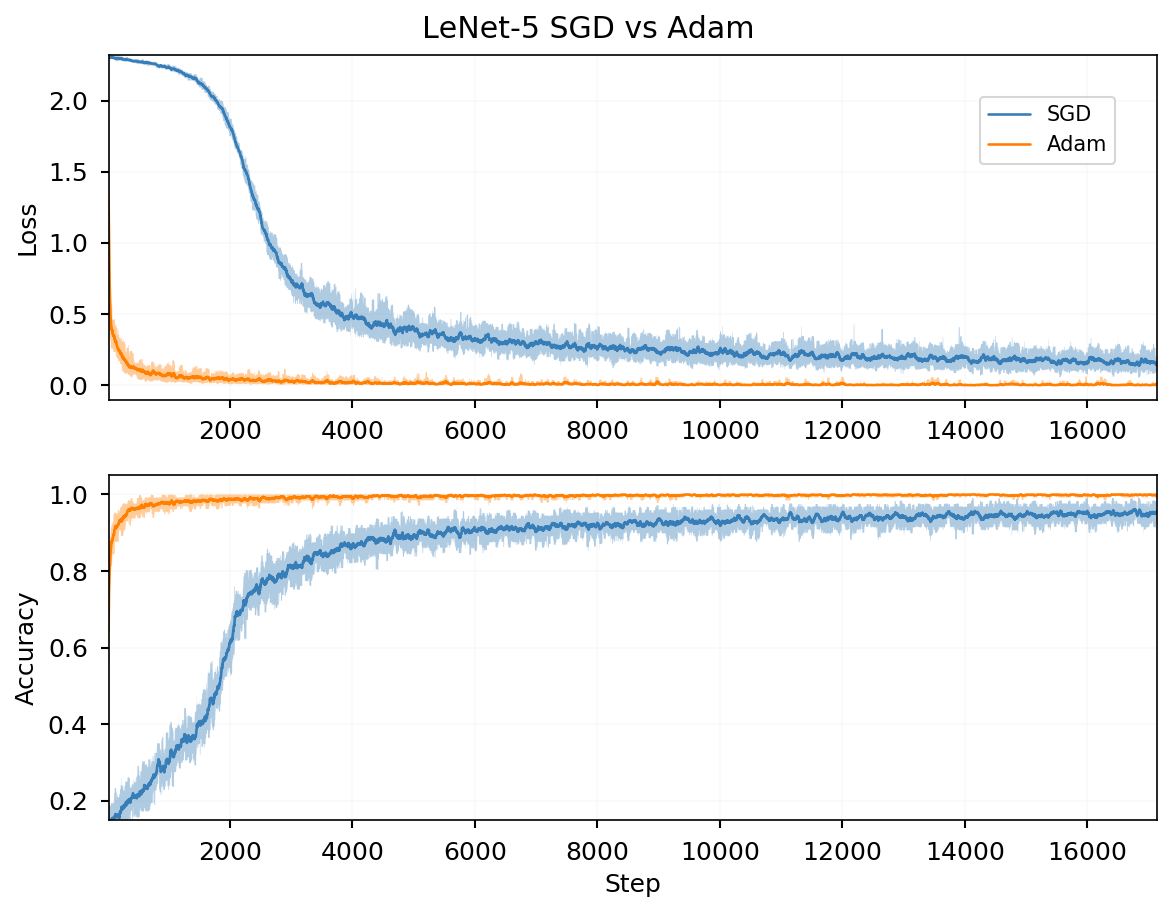

In [69]:
fig, (ax0, ax1) = plt.subplots(2, 1)

ea_1 = read_tbevents('./log_files_cnn_sgd/')
ea_2 = read_tbevents('./log_files_cnn_adam/')
data = pd.DataFrame(ea_1.Scalars('Loss_LeNet-5_SGD'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax0.plot(data_m.step, data_m.value, label='SGD')
ax0.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)


data = pd.DataFrame(ea_2.Scalars('Loss_LeNet-5_Adam'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax0.plot(data_m.step, data_m.value, label='Adam')
ax0.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)


data = pd.DataFrame(ea_1.Scalars('Accuracy_LeNet-5_SGD'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax1.plot(data_m.step, data_m.value)
ax1.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)


data = pd.DataFrame(ea_2.Scalars('Accuracy_LeNet-5_Adam'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax1.plot(data_m.step, data_m.value)
ax1.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)


ax0.set_ylabel('Loss')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Step')
# ax0.semilogx()
# ax1.semilogx()
ax0.set_ylim(-0.1)
ax1.set_ylim(0.15, 1.05)
ax0.legend()
fig.suptitle('LeNet-5 SGD vs Adam', y=1.01)

plt.show()

<b> Question 2.2.2</b> Try to add dropout (keep_prob = 0.75) before the first fully connected layer. You will use tf.nn.dropout for that purpose. What accuracy do you achieve on testing data?

**Accuracy achieved on testing data:** ...

In [10]:
def LeNet5_Model_Dropout(image, keep_prob=1.0):    
    # your implementation goes here
    # your inmplementation goes here
    with tf.name_scope("layer1"):
        out0 = tf.reshape(image, [-1, 28, 28, 1]) # [batch_size, 28, 28, 1]
        w1 = weight_variable(shape=[5, 5, 1, 6])
        b1 = bias_variable(shape=[6])
        out1 = tf.nn.conv2d(input=out0, filter=w1, strides=[1,1,1,1], padding="SAME") + b1 # [batch_size, 28, 28, 6]
        out1 = tf.nn.relu(features=out1) # [batch_size, 28, 28, 6]
        out1 = tf.nn.max_pool(value=out1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME") # [batch_size, 14, 14, 6]
    
    with tf.name_scope("layer2"):
        w2 = weight_variable(shape=[5, 5, 6, 16])
        b2 = bias_variable(shape=[16])
        out2 = tf.nn.conv2d(input=out1, filter=w2, strides=[1,1,1,1], padding="VALID") + b2 # [batch_size, 10, 10, 16]
        out2 = tf.nn.relu(features=out2) # [batch_size, 10, 10, 16]
        out2 = tf.nn.max_pool(value=out2, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME") # [batch_size, 5, 5, 16]
        
    with tf.name_scope("flatten"):
        conv_feature = tf.reshape(out2, [-1, 5 * 5 * 16])
        
    with tf.name_scope("dropout"):
        dropout = tf.nn.dropout(x=conv_feature, keep_prob=keep_prob)
    
    with tf.name_scope("layer3"):
        w3 = weight_variable(shape=[5 * 5 * 16, 120])
        b3 = bias_variable(shape=[120])
        out3 = tf.matmul(a=dropout, b=w3) + b3 # [batch_size, 120]
        out3 = tf.nn.relu(features=out3) # [batch_size, 120]
        
    with tf.name_scope("layer4"):
        w4 = weight_variable(shape=[120, 84])
        b4 = bias_variable(shape=[84])
        out4 = tf.matmul(a=out3, b=w4) + b4 # [batch_size, 84]
        out4 = tf.nn.relu(features=out4) # [batch_size, 84]
    
    with tf.name_scope("layer5"):
        w5 = weight_variable(shape=[84, 10])
        b5 = bias_variable(shape=[10])
        out5 = tf.matmul(a=out4, b=w5) + b5 # [batch_size, 10]
        #out5 = tf.nn.softmax(out5) # [batch_size, 10]
    
    return out5

tf.reset_default_graph()
# your implementation goes here
# Parameters
learning_rate = 0.001
training_epochs = 40
batch_size = 128
test_batch_size = 5000
display_step = 1
logs_path = 'log_files_cnn_dropout/'

# Model, loss function and accuracy
# tf Graph Input:  mnist data image of shape 28*28=784
x = tf.placeholder(tf.float32, [None, 784], name="InputData")
# 0-9 digits recognition,  10 classes
y = tf.placeholder(tf.float32, [None, 10], name="LabelData")
# Define keep_prob
keep_prob = tf.placeholder(tf.float32, (), name="keep_prob")

# Define model
with tf.name_scope("Model"):
    pred = LeNet5_Model_Dropout(image=x, keep_prob=keep_prob)
    
# Define loss function
with tf.name_scope('Loss'):
    # Minimize error using cross entropy
    # We use tf.clip_by_value to avoid having too low numbers in the log function
    # cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(tf.clip_by_value(pred, epsilon, 1.0)), reduction_indices=1))
    # Define cross-entropy cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=pred, labels=y))

# Define optimizer
with tf.name_scope('Adam'):
    # Gradient Descent
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
# Define accuracy
with tf.name_scope('Accuracy'):
    # Accuracy
    acc = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))

# Define saver to save model
with tf.name_scope('Saver'):
    saver = tf.train.Saver()
    
# Initializing the variables
init = tf.global_variables_initializer()
# Create a summary to monitor cost tensor
tf.summary.scalar("Loss_LeNet-5_Dropout_Adam", cost)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("Accuracy_LeNet-5_Dropout_Adam", acc)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

# Initializing the variables
def train(init, sess, logs_path, n_epochs, batch_size, optimizer, cost, merged_summary_op):
    # optimizer and cost are the same kinds of objects as in Section 1
    # Train your model
    # Initialize variable
    sess.run(init)
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    # Training cycle
    for epoch in range(n_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=(i==0))
            # Run optimization op (backprop), cost op (to get loss value)
            # and summary nodes
            _, c, summary = sess.run([optimizer, cost, merged_summary_op],
                                     feed_dict={x: batch_xs, y: batch_ys, keep_prob: 0.75})
            # Write logs at every iteration
            summary_writer.add_summary(summary, epoch * total_batch + i)
            # Compute average loss
            avg_cost += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            train_acc = 0.0
            total_batch = int(mnist.train.num_examples/test_batch_size)
            for i in range(total_batch):
                train_acc = train_acc + acc.eval({x:mnist.train.images[i * test_batch_size : (i + 1) * test_batch_size], 
                                                  y:mnist.train.labels[i * test_batch_size : (i + 1) * test_batch_size],
                                                  keep_prob: 1.0})
            train_acc = train_acc / total_batch 
            val_acc = acc.eval({x:mnist.validation.images, y:mnist.validation.labels, keep_prob: 1.0})
            print("Epoch", epoch + 1, ", average loss per minibatch:", avg_cost, ", train_acc:", train_acc, ", val_acc:", val_acc)

    print("Optimization Finished!")
    file_path = "./model_cnn_dropout_epoch" + str(n_epochs) + "/model.ckpt"
    save_path = saver.save(sess, file_path)
    summary_writer.flush()

    # Test model
    # Calculate accuracy
    print("Accuracy on testing data:", acc.eval({x: mnist.test.images, y: mnist.test.labels, keep_prob: 1.0}))
    return

with tf.Session() as sess:
    train(init, sess, logs_path, training_epochs, batch_size, optimizer, cost, merged_summary_op)

Epoch 1 , average loss per minibatch: 0.39931087973929247 , train_acc: 0.9679090922529047 , val_acc: 0.9712
Epoch 2 , average loss per minibatch: 0.11443698668900207 , train_acc: 0.9817090901461515 , val_acc: 0.9822
Epoch 3 , average loss per minibatch: 0.08318746664142343 , train_acc: 0.9859636371785944 , val_acc: 0.985
Epoch 4 , average loss per minibatch: 0.06657902635026096 , train_acc: 0.9890000007369302 , val_acc: 0.9866
Epoch 5 , average loss per minibatch: 0.05766044335878325 , train_acc: 0.9903090975501321 , val_acc: 0.9868
Epoch 6 , average loss per minibatch: 0.050398648962908195 , train_acc: 0.9913636337627064 , val_acc: 0.9874
Epoch 7 , average loss per minibatch: 0.04645233750690667 , train_acc: 0.9921272776343606 , val_acc: 0.9866
Epoch 8 , average loss per minibatch: 0.041492141301837 , train_acc: 0.9941999912261963 , val_acc: 0.9884
Epoch 9 , average loss per minibatch: 0.03797805719869971 , train_acc: 0.9945999925786798 , val_acc: 0.9902
Epoch 10 , average loss per mi

Starting loading the event file in ./log_files_cnn_sgd/. Might take a while


INFO:tensorflow:No path found after ./log_files_cnn_sgd/events.out.tfevents.1558686277.py-notebook0-81115-prod


Starting loading the event file in ./log_files_cnn_adam/. Might take a while


INFO:tensorflow:No path found after ./log_files_cnn_adam/events.out.tfevents.1558687502.py-notebook0-81115-prod


Starting loading the event file in ./log_files_cnn_dropout/. Might take a while


INFO:tensorflow:No path found after ./log_files_cnn_dropout/events.out.tfevents.1558647296.py-notebook0-81103-prod


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


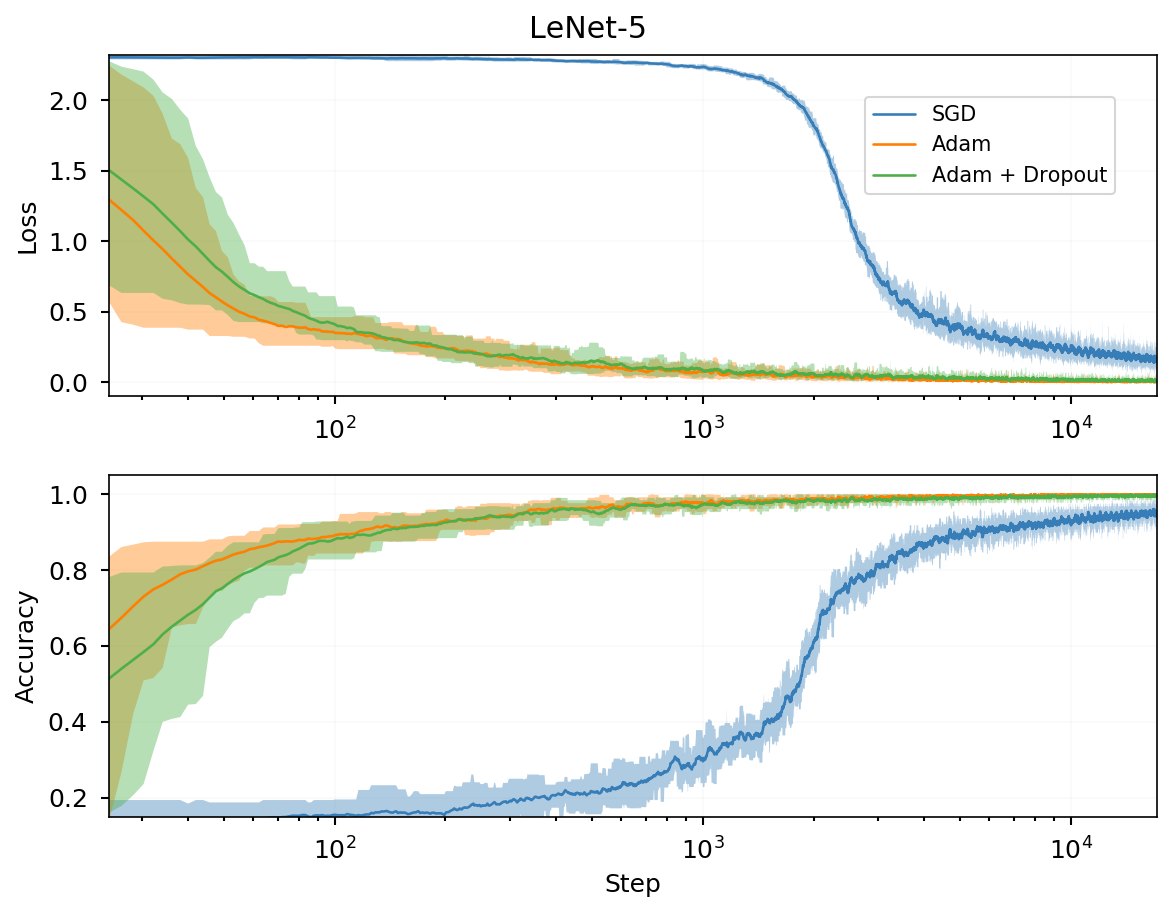

In [79]:
fig, (ax0, ax1) = plt.subplots(2, 1)

ea_1 = read_tbevents('./log_files_cnn_sgd/')
ea_2 = read_tbevents('./log_files_cnn_adam/')
ea_3 = read_tbevents('./log_files_cnn_dropout/')

data = pd.DataFrame(ea_1.Scalars('Loss_LeNet-5_SGD'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax0.plot(data_m.step, data_m.value, label='SGD')
ax0.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)


data = pd.DataFrame(ea_2.Scalars('Loss_LeNet-5_Adam'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax0.plot(data_m.step, data_m.value, label='Adam')
ax0.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)


data = pd.DataFrame(ea_3.Scalars('Loss_LeNet-5_Dropout_Adam'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax0.plot(data_m.step, data_m.value, label='Adam + Dropout')
ax0.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)



data = pd.DataFrame(ea_1.Scalars('Accuracy_LeNet-5_SGD'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax1.plot(data_m.step, data_m.value)
ax1.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)


data = pd.DataFrame(ea_2.Scalars('Accuracy_LeNet-5_Adam'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax1.plot(data_m.step, data_m.value)
ax1.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)

data = pd.DataFrame(ea_3.Scalars('Accuracy_LeNet-5_Dropout_Adam'))
data_m = data.rolling(25).mean()
data_s2 = data.rolling(25).quantile(0.95)
data_s1 = data.rolling(25).quantile(0.05)
ax1.plot(data_m.step, data_m.value)
ax1.fill_between(data_m.step, data_s1.value, data_s2.value, alpha=0.4)


ax0.set_ylabel('Loss')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Step')
ax0.set_ylim(-0.1)
ax1.set_ylim(0.15, 1.05)
ax0.semilogx()
ax1.semilogx()

ax0.legend()
fig.suptitle('LeNet-5', y=1.01)

plt.show()

**Comment**: As the model is faily small, the difference here is pretty marginal. We see that dropout slows down a little bit the convergence in the early stage of the optimization and it seems to slightly improve generalization capability (as shown by an slightly higher test accuracy)